Modelo para la predicción del valor de una vivienda con datos de idealista

La idea principal es que para cada vivienda que se quiera estimar el valor de mercado, se haga una estimación de suu valor utilizando únicamente las viviendas más cercanas y aplicando una regresión lineal con las variables más relevantes.

Es importante tener en cuenta a la hora de escoger el subgrupo de viviendas relevantes, no solo la cercanía si no también otras variables como el código postal para tener en cuenta que existirán barrios adyacentes con precios muy diferentes.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
import math
import geopy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option("display.max_columns", None)

df = pd.read_csv("opportunities_dataset.csv")


In [10]:
df.head()

,AireAcondicionado,AreasVerdes,ArmarioEmpotrado,Ascensor,AñoConstruccion,Balcon,Barrio,CodigoPostal,Distrito,Estado,InteriorExterior,Jardin,Latitud,Longitud,MetrosConstruidos,MetrosUtiles,Municipio,NumBaños,NumHabitaciones,NumPlanta,Orientacion,Piscina,Precio,PrecioM2,Profesional,Terraza,Tipologia,Titulo,Trastero
0,False,False,False,Unknown,2002.0000,False,Sarrià,8017,Sarrià-Sant Gervasi,Segunda mano/buen estado,NaN,True,41.4026,2.1080,850,NaN,Barcelona,6.0000,6.0000,NaN,"sur, este, oeste",True,3400000,4000,True,False,Chalet,Casa o chalet independiente en venta en Sarrià,False
1,True,False,False,False,NaN,False,El Raval,8001,Ciutat Vella,Segunda mano/buen estado,Exterior,False,41.3778,2.1665,75,72.0000,Barcelona,1.0000,3.0000,4.0000,sur,False,239000,3187,True,False,Piso,Piso en venta en calle de la Cera,False
2,False,False,False,False,NaN,True,Vista Alegre,28044,Carabanchel,Segunda mano/buen estado,Exterior,False,40.3839,-3.7473,70,NaN,Madrid,1.0000,2.0000,1.0000,"norte, sur",False,139900,1999,True,True,Piso,Piso en venta en Vista Alegre,False
3,False,False,False,False,NaN,False,Ciudad Jardín,28002,Chamartín,Segunda mano/para reformar,Exterior,False,40.4466,-3.6718,50,NaN,Madrid,1.0000,2.0000,1.0000,NaN,False,210000,4200,True,False,Piso,Piso en venta en Ciudad Jardín,False
4,False,False,False,True,NaN,True,El Clot,8026,Sant Martí,Segunda mano/buen estado,Exterior,False,41.4083,2.1860,85,NaN,Barcelona,2.0000,3.0000,2.0000,NaN,False,359000,4224,True,False,Piso,Piso en venta en calle d'Aragó,False


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28733 entries, 0 to 28732
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   AireAcondicionado  28733 non-null  bool   
 1   AreasVerdes        28733 non-null  bool   
 2   ArmarioEmpotrado   28733 non-null  bool   
 3   Ascensor           28733 non-null  object 
 4   AñoConstruccion    17590 non-null  float64
 5   Balcon             28733 non-null  bool   
 6   Barrio             28733 non-null  object 
 7   CodigoPostal       28733 non-null  int64  
 8   Distrito           28733 non-null  object 
 9   Estado             27328 non-null  object 
 10  InteriorExterior   24179 non-null  object 
 11  Jardin             28733 non-null  bool   
 12  Latitud            28733 non-null  float64
 13  Longitud           28733 non-null  float64
 14  MetrosConstruidos  28733 non-null  int64  
 15  MetrosUtiles       13892 non-null  float64
 16  Municipio          287

In [12]:
df.describe()

,AñoConstruccion,CodigoPostal,Latitud,Longitud,MetrosConstruidos,MetrosUtiles,NumBaños,NumHabitaciones,NumPlanta,Precio,PrecioM2
count,17590.0000,28733.0000,28733.0000,28733.0000,28733.0000,13892.0000,28716.0000,28075.0000,25285.0000,28733.0000,28733.0000
mean,1961.5424,19453.7133,40.8437,-1.1724,119.3109,93.7897,1.7624,2.8705,2.4964,543181.9181,4310.9947
std,37.5568,9912.9729,0.4848,2.8984,154.0381,128.5126,1.0990,1.2840,2.0478,705637.9547,2136.6812
min,1700.0000,1001.0000,40.3305,-3.8370,13.0000,1.0000,1.0000,1.0000,-1.0000,39000.0000,96.0000
25%,1950.0000,8020.0000,40.4166,-3.6982,65.0000,58.0000,1.0000,2.0000,1.0000,205000.0000,2841.0000
50%,1967.0000,28005.0000,40.4669,-3.6396,87.0000,75.0000,1.0000,3.0000,2.0000,339000.0000,3919.0000
75%,1982.0000,28027.0000,41.3943,2.1655,125.0000,98.0000,2.0000,3.0000,4.0000,590000.0000,5185.0000
max,3012.0000,50100.0000,41.4671,2.2216,16301.0000,12075.0000,15.0000,17.0000,9.0000,21000000.0000,25938.0000


<AxesSubplot:>

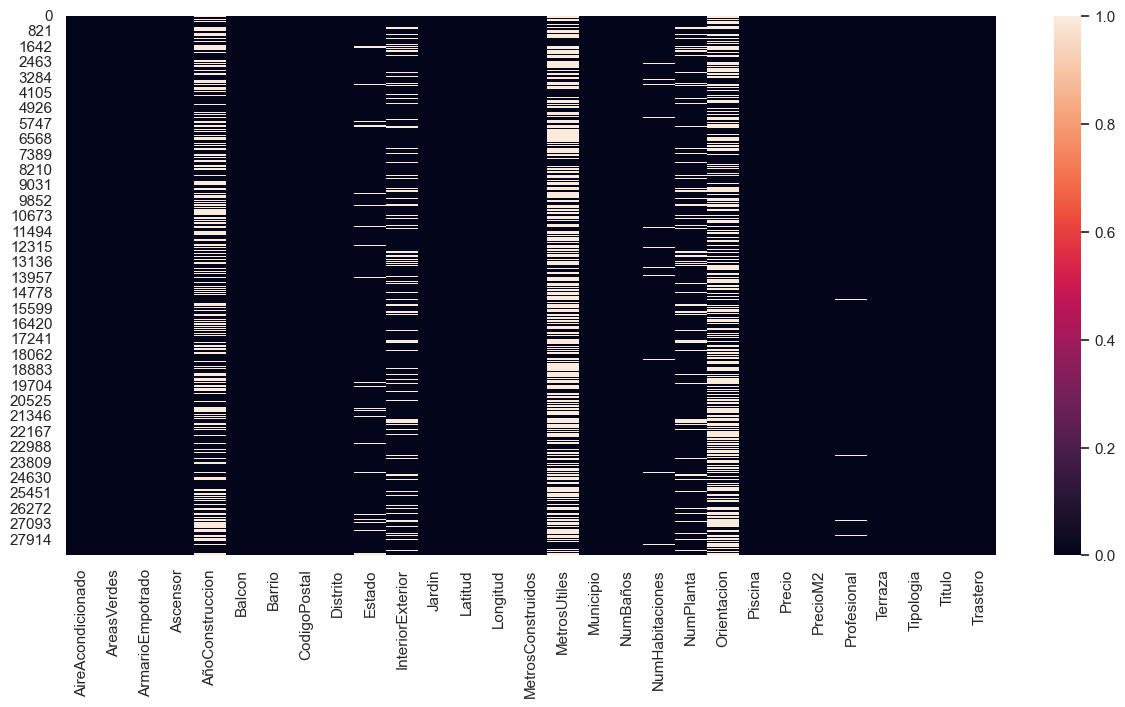

In [13]:
# Evaluamos las columnas la cantidad de datos nulos que tenemos en el datasheet
sns.set(rc={'figure.figsize':(15,7)})
sns.heatmap(df_simple.isnull())

In [15]:
#Eliminamos las entradas que no tienen numero de habitaciones relleno
df = df.dropna(subset=['NumHabitaciones'])
#Eliminamos las entradas que no tienen numero de baños relleno
df = df.dropna(subset=['NumBaños'])
#Eliminamos las entradas que no tienen el Estado relleno
df = df.dropna(subset=['Estado'])

In [16]:
# Hay que tratar algunas columnas que tiene valores que no son útiles

# Convertimos la variable profesional en bool, poniendo a falso en caso de null
df['Profesional'].fillna('false', inplace=True)
df['Profesional'] = df['Profesional'].replace({'FALSO': 'False', 'VERDADERO': 'True'})
df['Profesional'] = df['Profesional'].astype(bool)

# Cambiamos los valores 'No informado' a 'false' ya que son casas que no tienen ascensor
df['Ascensor'] = df['Ascensor'].replace({'False': 'False', 'True': 'True', 'No informado': 'False'})
df['Ascensor'] = df['Ascensor'].astype(bool)


In [17]:
# Nos quedamos con los inmuebles de Madrid y Barcelona para evaluarlos por separado
df_Madrid = df[df['Municipio'] == 'Madrid']
df_Madrid['NumPlanta'] = df_Madrid['NumPlanta'].fillna(df_Madrid['NumPlanta'].mean())
df_Madrid['NumPlanta'] = [round(valor, 2) for valor in df_Madrid['NumPlanta']]
df_Madrid['AñoConstruccion'] = df_Madrid['AñoConstruccion'].fillna(df_Madrid['AñoConstruccion'].mean())
df_Madrid['AñoConstruccion'] = [round(valor, 2) for valor in df_Madrid['AñoConstruccion']]

<AxesSubplot:>

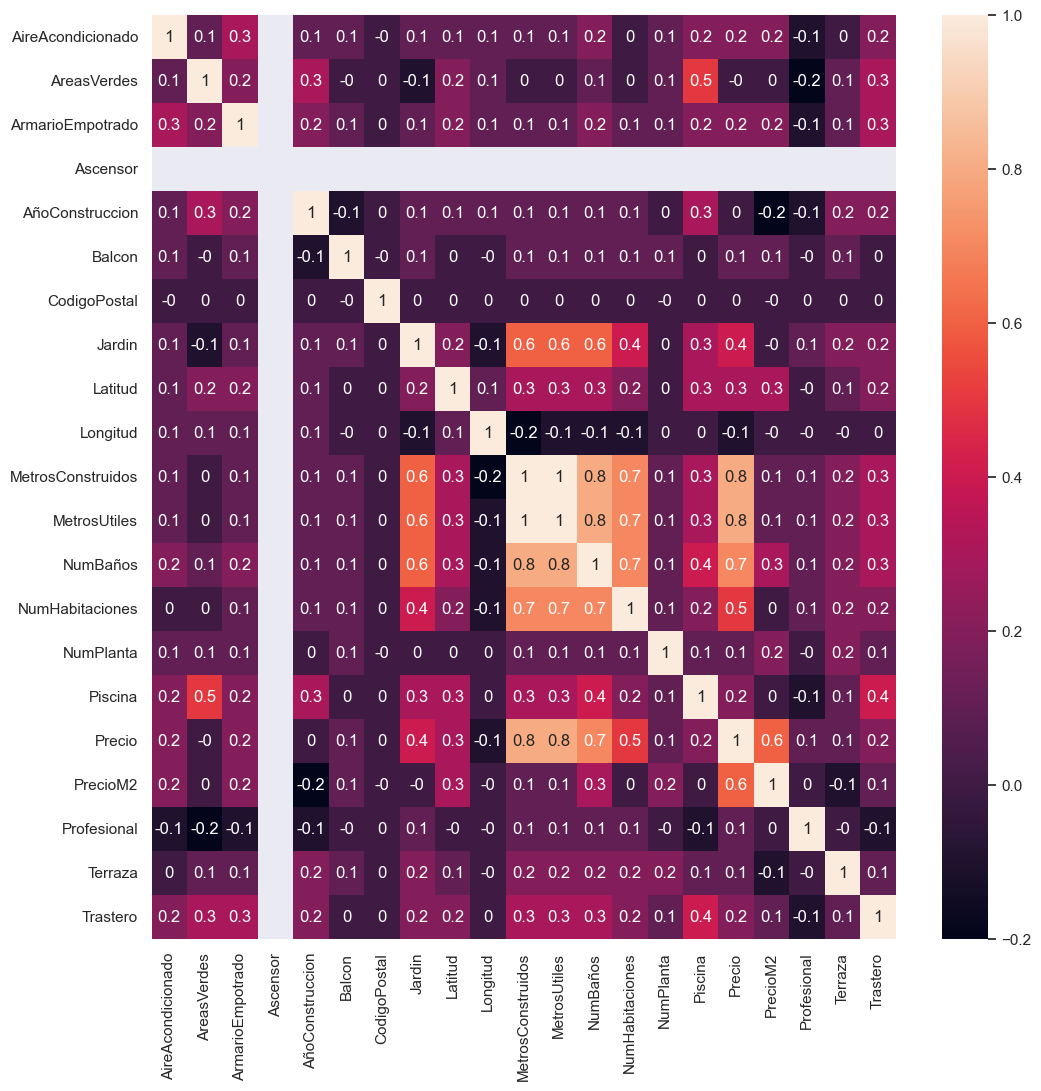

In [18]:
plt.figure(figsize=(12,12))
sns.heatmap(df_Madrid.corr().round(decimals=1), annot=True)

In [19]:
# Partir el datasheet entre training y test (95% - 5%)
df_train, df_test = train_test_split(df_Madrid, test_size=0.05, random_state=42)
df_test = df_test.reset_index(drop=True)


In [20]:
# BUCLE QUE RECORRA LOS INPUTS PARA EVALUAR COMO FUNCIONA EL MODELO
longitud_minima_train = 6
i=0;
precio_estimado = []
error_precio = []

while(i<len(df_test)):
      df_train_i = df_train
      ## FILTROS A UTILIZAR PARA CONSTRUIR EL CONJUNTO DE PISOS PARA REALIZAR LA REGRESION LINEAL
    
      # Filtrar el title por tipo de edificio que estemos evaluando
      df_train_temp = df_train_i[df_train_i['Tipologia'] == df_test.loc[i, 'Tipologia']]
      if df_train_temp.shape[0] >= longitud_minima_train:
          df_train_i = df_train_temp
        
      # Filtrar por estado 'Estado' del inmueble
      df_train_temp = df_train_i[df_train_i['Estado'] == df_test.loc[i, 'Estado']]
      if df_train_temp.shape[0] >= longitud_minima_train:
          df_train_i = df_train_temp
        
      # Filtrar por los inmuebles que pertenezcan al mismo codigo postal
      df_train_temp = df_train_i[df_train_i['CodigoPostal'] == df_test.loc[i,'CodigoPostal']]
      if df_train_temp.shape[0] >= longitud_minima_train:
          df_train_i = df_train_temp
        
      # Filtrar por si tiene o no tiene ascensor
      df_train_temp = df_train_i[df_train_i['Ascensor'] == df_test.loc[i, 'Ascensor']]
      if df_train_temp.shape[0] >= longitud_minima_train:
          df_train_i = df_train_temp
      
      # Filtrar por superficie para quedarnos unicamente con los valores mas cercanos (e.g. +-15)
      df_train_temp = df_train_i[(df_train_i['MetrosConstruidos'] > (df_test.loc[i, 'MetrosConstruidos']-15)) & (df_train_i['MetrosConstruidos'] < (df_test.loc[i, 'MetrosConstruidos']+15))]
      if df_train_temp.shape[0] >= longitud_minima_train:
          df_train_i = df_train_temp
        
      # Modelo a implementar de regresion lineal con las viviendas resultantes del filtrado
      # Preparar los datos de entrenamiento
      x_train = df_train_i[['MetrosConstruidos']]
      y_train = df_train_i['Precio']
    
      # Crear el modelo de regresión lineal
      modelo = LinearRegression(fit_intercept=True, normalize=True)
    
      # Sacamos un diagrama para entender la dispersion de precios que estamos obteniendo
      #plt.scatter(x_train[['MetrosConstruidos']], y_train)
      #plt.title('Scatter plot vivendas filtradas')
      #plt.xlabel('Metros cuadrados de la vivienda')
      #plt.ylabel('Precio del inmueble')
      #plt.show()
        
      # Entrenar el modelo
      modelo.fit(x_train, y_train)
        
      # Predecir el precio utilizando los valores del conjunto de prueba 
      x_pred = df_test.loc[i,['MetrosConstruidos']]
      y_real = df_test['Precio']
      precio_estimado.append(modelo.predict(x_pred.array.reshape(1, -1)))
      # print(precio_estimado[i])
      error_precio.append ((abs(precio_estimado[i]-y_real[i])/y_real[i])*100)
        
      i += 1

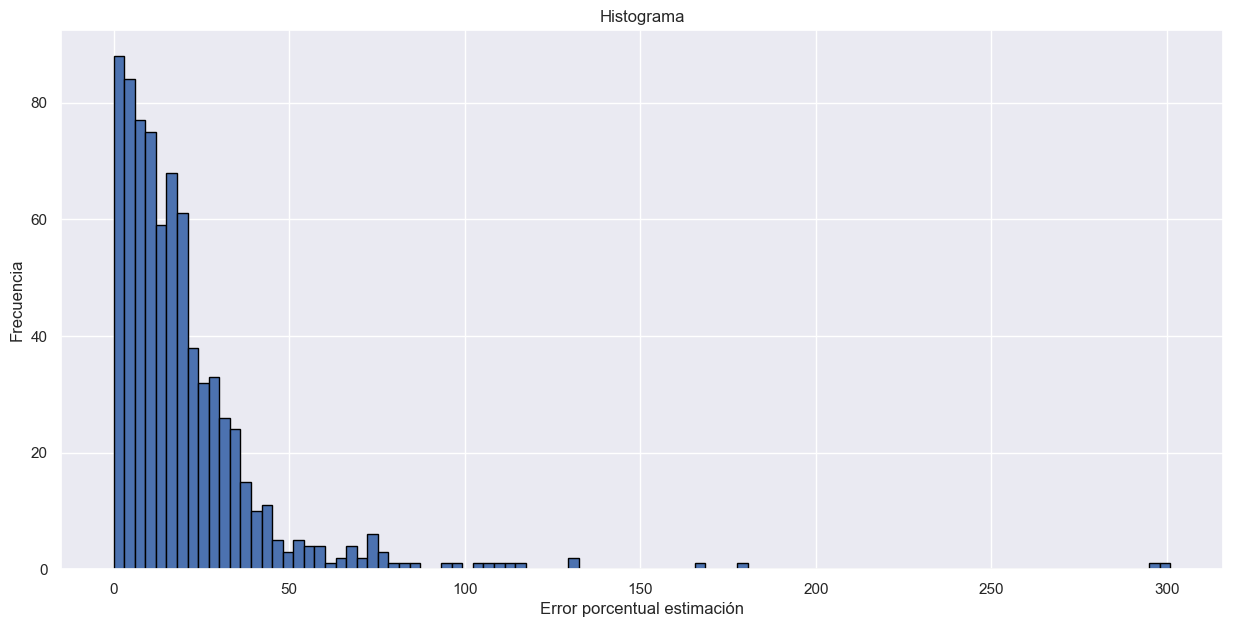

Error medio obtenido: 20.21%


In [21]:
# EVALUACION DE MODELO

# hacer un histograma y evaluar cómo se comporta el modelo
error_array = np.array(error_precio)
plt.hist(error_array, bins=100, edgecolor='black')
plt.title('Histograma')
plt.xlabel('Error porcentual estimación')
plt.ylabel('Frecuencia')
plt.show()

print('Error medio obtenido: '+str(f"{error_array.mean():.2f}")+'%')